In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.applications import vgg16 ,resnet50 ,xception ,inception_v3 ,inception_resnet_v2 ,resnet_v2 ,nasnet
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate ,Dense ,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score

import os
import cv2
import zipfile    #Unzip  data
import shutil     #Manipulate data in disk
from tqdm import tqdm   #Gives indication of how much for loop progressed

## Data preparation
To make our data easier to be read which contain 120 train class we will unzip the data file and put in that way:

    train data:

        -Class 1:
            image1.png
            image2.png
            ...
        -Class 2:
            image2.png
            image1.png
            ...
        -Class 3:
            ...

    test data:
        -images:
            image1.png
            image2.png
            ...

this directory order allows us to use [image_dataset_from_directory()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function
which converts our image data into [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) format directly.

(Note: [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) format is memory & time efficient while training model)

In [2]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('test/images')

In [2]:
df = pd.read_csv('./input/dog-breed-identification/labels.csv')
breeds  = list(df['breed'])       #list of training examples breeds
s_breed = df['breed']
unq_breed = s_breed.unique()      #All 120 breeds
id = list(df['id'])               #list of trainig examples id

In [5]:
#make a directory for each breed in the training directory
for breed in list(unq_breed):
  os.mkdir('train/' + breed)

In [6]:
#make a function that moves all training images to a breed directory according to thier label
#If image labeled as 'Boston bull' it will move to the 'train/boston_bull' directory 
def move_train_images(breeds , ids ,image_path):
  lst = os.listdir(image_path)
  for name in tqdm(lst):
    for i , id in enumerate(ids):
      if name.split('.')[0] == id:
        shutil.copy(image_path + name , 'train/' + breeds[i])

In [8]:
move_train_images(breeds , id , './input/dog-breed-identification/train/')

#since test data is not labeled, all images will be moved in 'test/images' directory
for img in tqdm(os.listdir('./input/dog-breed-identification/test/')):
  shutil.copy('./input/dog-breed-identification/test/' + img , './test/images')

100%|██████████| 10357/10357 [01:52<00:00, 91.89it/s] 


In [156]:
path = './train/'
for fold in os.listdir(path):
    i = 1 
    loc = path + fold+ '/'
    for file in os.listdir(loc)[-10:]:
        shutil.move(loc+file , './test/'+fold+'_'+str(i)+'.jpg')
        i += 1

In [2]:
train_dir = './train'
test_dir = './test'

#read csv data
train_labels = pd.read_csv('./input/dog-breed-identification/labels.csv', index_col = 'id')
#submission=pd.read_csv('./input/dog-breed-identification/sample_submission.csv')

In [3]:
train_size = len(os.listdir(train_dir))
test_size = len(os.listdir(test_dir))

print(train_size,test_size)

120 1200


In [60]:
train_labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [4]:
N_EPOCHS = 50
BATCH_SIZE = 10
IMG_HEIGHT = 331
IMG_WIDTH = 331

## Prepare the Datasets

In [6]:
train_ds = image_dataset_from_directory(
  directory = train_dir,
  labels = 'inferred',
  label_mode='int',
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle = True,
  seed=17,
  validation_split=0.2,
  subset="training",
)

Found 9022 files belonging to 120 classes.
Using 7218 files for training.


In [7]:
val_ds = image_dataset_from_directory(
  directory = train_dir,
  labels = 'inferred',
  label_mode='int',
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle = True,
  seed=17,
  validation_split=0.2,
  subset="validation",
)

Found 9022 files belonging to 120 classes.
Using 1804 files for validation.


In [5]:
test_ds = image_dataset_from_directory(
  directory = test_dir,
  label_mode= None,
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle = False,
  seed=1234
)

Found 1200 files belonging to 1 classes.


## Optimize the dataset for performance

here is a to do list to optimize the [data_performance](https://www.tensorflow.org/guide/data_performance)

We will use only one method:

[.prefetch()](https://www.tensorflow.org/guide/data_performance#prefetching) overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation layer

In [10]:
data_augmentation = Sequential(
  [
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
  ]
)

## Build a Model

In [11]:
base_model_1 = xception.Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

base_model_2 = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

#base_model_3 = inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

base_model_4 = resnet_v2.ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

#base_model_5 = nasnet.NASNetLarge(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

# train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
base_model_1.trainable = False
base_model_2.trainable = False
#base_model_3.trainable = False
base_model_4.trainable = False
#base_model_5.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
aug_inputs = data_augmentation(inputs)

## <-----  Xception   -----> ##
x1 = xception.preprocess_input(aug_inputs)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here by passing `training=False`.
x1 = base_model_1(x1, training=False)
x1 = GlobalAveragePooling2D()(x1)

### <-----  InceptionV3   -----> ##
x2 = inception_v3.preprocess_input(aug_inputs)
x2 = base_model_2(x2, training=False)
x2 = GlobalAveragePooling2D()(x2)
#
### <-----  InceptionResNetV2   -----> ##
#x3 = inception_resnet_v2.preprocess_input(aug_inputs)
#x3 = base_model_3(x3, training=False)
#x3 = GlobalAveragePooling2D()(x3)
#
### <-----  ResNet152V2   -----> ##
x4 = resnet_v2.preprocess_input(aug_inputs)
x4 = base_model_4(x4, training=False)
x4 = GlobalAveragePooling2D()(x4)

## <-----  NASNetLarge   -----> ##
#x5 = nasnet.preprocess_input(aug_inputs)
#x5 = base_model_5(x5, training=False)
#x5 = GlobalAveragePooling2D()(x5)

## <-----  Concatenation  -----> ##
x = Dropout(.7)(x1)
outputs = Dense(120, activation='softmax')(x)
model1 = Model(inputs, outputs)

x = Dropout(.7)(x2)
outputs = Dense(120, activation='softmax')(x)
model2 = Model(inputs, outputs)

x = Dropout(.7)(x4)
outputs = Dense(120, activation='softmax')(x)
model4 = Model(inputs, outputs)

x = Concatenate()([x1, x2, x4])
x = Dropout(.7)(x)
outputs = Dense(120, activation='softmax')(x)
model_comb = Model(inputs, outputs)

In [12]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 331, 331, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 11, 11, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [13]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 331, 331, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 9, 9, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [14]:
model4.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 331, 331, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 11, 11, 2048)      58331648  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0   

In [15]:
model_comb.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 331, 331, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 331, 331, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
tf.math.truediv_1 (TFOpLambda)  (None, 331, 331, 3)  0           sequential[0][0]                 
____________________________________________________________________________________________

## Training the Model

In [16]:
optimizer = Adam(learning_rate=0.001)
model1.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
model2.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
model4.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
model_comb.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)

In [19]:
EarlyStop_callback = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

In [20]:
history = model1.fit(
    train_ds,
    epochs=15,  
    validation_data=val_ds,
    callbacks=[EarlyStop_callback]
)
model1.save('models/model1')

Epoch 1/15
722/722 [==============================] - 223s 297ms/step - loss: 1.5095 - accuracy: 0.6827 - val_loss: 0.4165 - val_accuracy: 0.8897
Epoch 2/15
722/722 [==============================] - 311s 431ms/step - loss: 0.5116 - accuracy: 0.8523 - val_loss: 0.3295 - val_accuracy: 0.9030
Epoch 3/15
722/722 [==============================] - 327s 453ms/step - loss: 0.4291 - accuracy: 0.8703 - val_loss: 0.3150 - val_accuracy: 0.9085
Epoch 4/15
722/722 [==============================] - 316s 437ms/step - loss: 0.4000 - accuracy: 0.8721 - val_loss: 0.3135 - val_accuracy: 0.9024
Epoch 5/15
722/722 [==============================] - 311s 430ms/step - loss: 0.3628 - accuracy: 0.8849 - val_loss: 0.3071 - val_accuracy: 0.9080
Epoch 6/15
722/722 [==============================] - 308s 427ms/step - loss: 0.3522 - accuracy: 0.8867 - val_loss: 0.3069 - val_accuracy: 0.9030
Epoch 7/15
722/722 [==============================] - 300s 415ms/step - loss: 0.3340 - accuracy: 0.8918 - val_loss: 0.3015 -

c:\Users\prave\miniconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: models/model1\assets


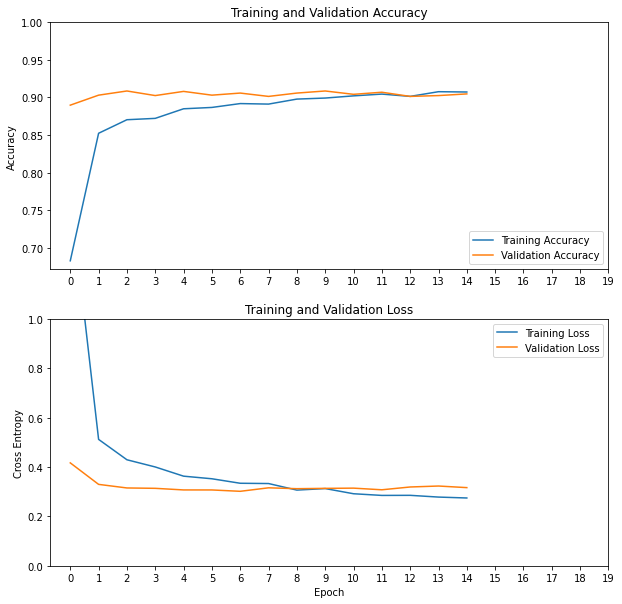

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xticks(list(range(20)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xticks(list(range(20)))
plt.xlabel('Epoch')
plt.show()

In [22]:
print("==========Starting Model 2==========")
history = model2.fit(
    train_ds,
    epochs=10,  
    validation_data=val_ds,
    #callbacks=[EarlyStop_callback]
)
model2.save('models/model2')
print("==========Model 2 Saved==========")

==========Starting Model 2==========
Epoch 1/10
722/722 [==============================] - 110s 145ms/step - loss: 1.9171 - accuracy: 0.5841 - val_loss: 0.4062 - val_accuracy: 0.8708
Epoch 2/10
722/722 [==============================] - 125s 172ms/step - loss: 0.9959 - accuracy: 0.7538 - val_loss: 0.3783 - val_accuracy: 0.8875
Epoch 3/10
722/722 [==============================] - 129s 178ms/step - loss: 0.8527 - accuracy: 0.7830 - val_loss: 0.3574 - val_accuracy: 0.8941
Epoch 4/10
722/722 [==============================] - 137s 190ms/step - loss: 0.7853 - accuracy: 0.7969 - val_loss: 0.3609 - val_accuracy: 0.9035
Epoch 5/10
722/722 [==============================] - 143s 198ms/step - loss: 0.7696 - accuracy: 0.8053 - val_loss: 0.3277 - val_accuracy: 0.9024
Epoch 6/10
722/722 [==============================] - 139s 192ms/step - loss: 0.7272 - accuracy: 0.8184 - val_loss: 0.3761 - val_accuracy: 0.8925
Epoch 7/10
722/722 [==============================] - 140s 193ms/step - loss: 0.6854 - 

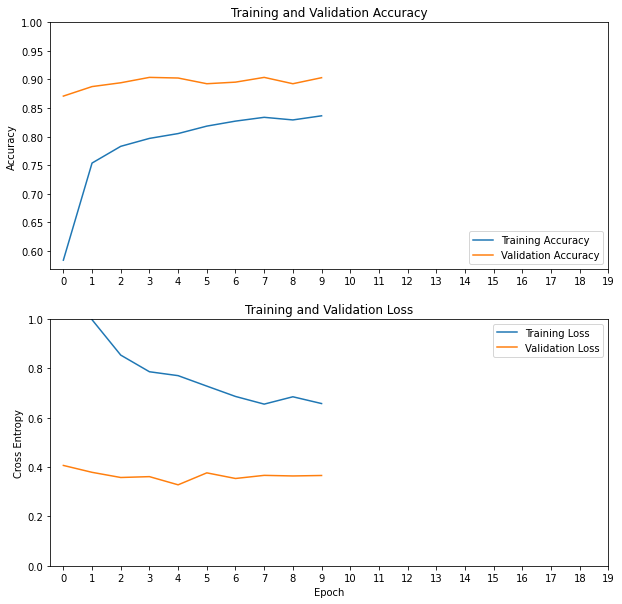

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xticks(list(range(20)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xticks(list(range(20)))
plt.xlabel('Epoch')
plt.show()

In [24]:
history = model4.fit(
    train_ds,
    epochs=10,  #I made only 2 epochs for checking. you can edit it to be = N_EPOCHS (N_EPOCHS variable = 50)
    validation_data=val_ds,
    #callbacks=[EarlyStop_callback]
)
model4.save('models/model4')

Epoch 1/10
722/722 [==============================] - 459s 626ms/step - loss: 2.9064 - accuracy: 0.4195 - val_loss: 0.6434 - val_accuracy: 0.8043
Epoch 2/10
722/722 [==============================] - 577s 799ms/step - loss: 1.4992 - accuracy: 0.6370 - val_loss: 0.5485 - val_accuracy: 0.8354
Epoch 3/10
722/722 [==============================] - 601s 832ms/step - loss: 1.2713 - accuracy: 0.6852 - val_loss: 0.5287 - val_accuracy: 0.8498
Epoch 4/10
722/722 [==============================] - 579s 801ms/step - loss: 1.1356 - accuracy: 0.7280 - val_loss: 0.5134 - val_accuracy: 0.8575
Epoch 5/10
722/722 [==============================] - 591s 819ms/step - loss: 1.0168 - accuracy: 0.7491 - val_loss: 0.5145 - val_accuracy: 0.8537
Epoch 6/10
722/722 [==============================] - 594s 823ms/step - loss: 0.9956 - accuracy: 0.7481 - val_loss: 0.4985 - val_accuracy: 0.8631
Epoch 7/10
722/722 [==============================] - 573s 794ms/step - loss: 0.8913 - accuracy: 0.7700 - val_loss: 0.5072 -

c:\Users\prave\miniconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: models/model4\assets


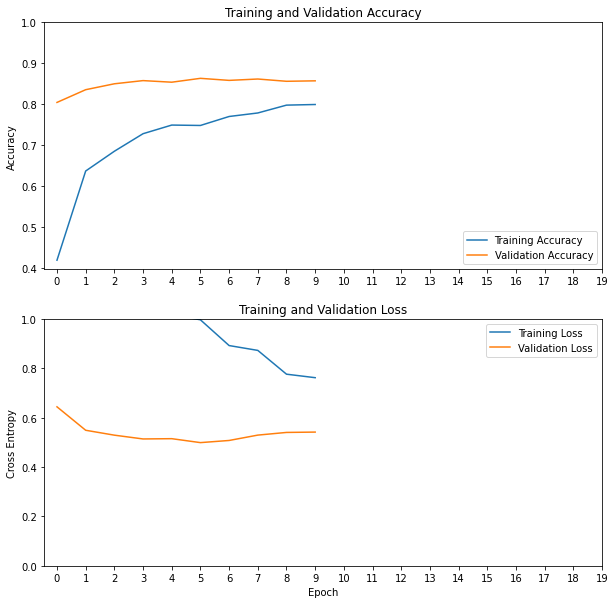

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xticks(list(range(20)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xticks(list(range(20)))
plt.xlabel('Epoch')
plt.show()

In [26]:
history_comb = model_comb.fit(
    train_ds,
    epochs=15,  
    validation_data=val_ds,
    #callbacks=[EarlyStop_callback]
)
model_comb.save('models/model_comb')

Epoch 1/15
722/722 [==============================] - 805s 1s/step - loss: 1.9670 - accuracy: 0.6441 - val_loss: 0.4812 - val_accuracy: 0.8880
Epoch 2/15
722/722 [==============================] - 876s 1s/step - loss: 1.0195 - accuracy: 0.7948 - val_loss: 0.4719 - val_accuracy: 0.8958
Epoch 3/15
722/722 [==============================] - 866s 1s/step - loss: 0.8330 - accuracy: 0.8249 - val_loss: 0.5261 - val_accuracy: 0.8919
Epoch 4/15
722/722 [==============================] - 1108s 2s/step - loss: 0.6902 - accuracy: 0.8512 - val_loss: 0.4895 - val_accuracy: 0.9091
Epoch 5/15
722/722 [==============================] - 1151s 2s/step - loss: 0.6367 - accuracy: 0.8605 - val_loss: 0.4931 - val_accuracy: 0.9058
Epoch 6/15
722/722 [==============================] - 1121s 2s/step - loss: 0.5924 - accuracy: 0.8684 - val_loss: 0.5285 - val_accuracy: 0.9013
Epoch 7/15
722/722 [==============================] - 1213s 2s/step - loss: 0.5668 - accuracy: 0.8756 - val_loss: 0.5275 - val_accuracy: 0.

c:\Users\prave\miniconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: models/model_comb\assets


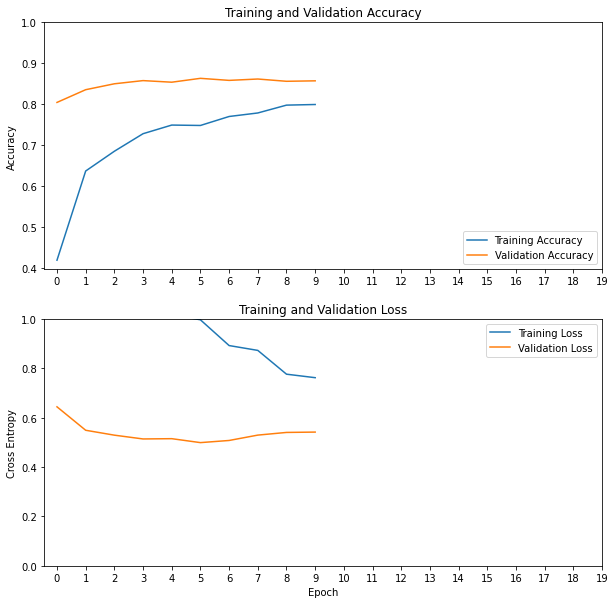

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xticks(list(range(20)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xticks(list(range(20)))
plt.xlabel('Epoch')
plt.show()

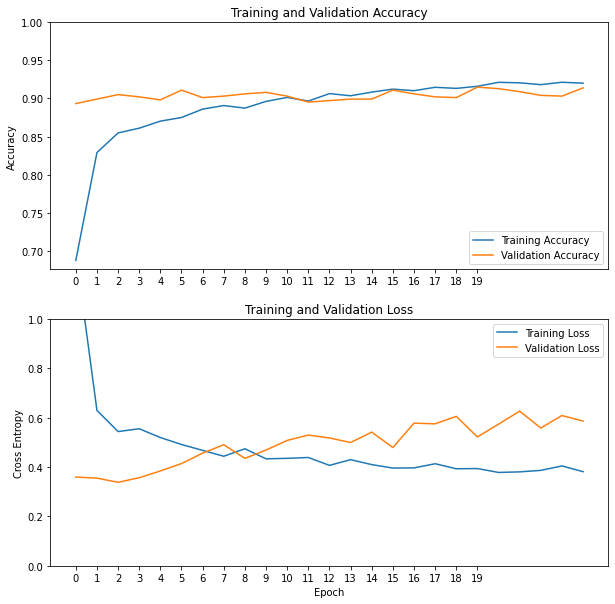

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xticks(list(range(20)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xticks(list(range(20)))
plt.xlabel('Epoch')
plt.show()

## Predict on Test Dataset

In [9]:
test_labels = []
for i in range(120):
    for j in range(10):
        test_labels.append(i)
len(test_labels)

1200

120/120 [==============================] - 79s 537ms/step


In [15]:
print(predictions.shape)
print(len(y_pred))

(1200, 120)
1200


In [19]:
#Ensemble
model = load_model('models/model_comb/')
predictions = model.predict(
    test_ds,
    batch_size = 128,
    verbose=1         
)
y_pred = []
for prediction in predictions:
    y_pred.append(np.argmax(prediction))
print('recall:',recall_score(test_labels, y_pred, average='weighted'))
print('precision:',precision_score(test_labels, y_pred, average='weighted'))
print('F1 Score:', f1_score(test_labels, y_pred, average='weighted'))

120/120 [==============================] - 65s 513ms/step
recall: 0.9191666666666667
precision: 0.9214549570799572
F1 Score: 0.914783910252513


In [17]:
#xception
model = load_model('models/model1/')
predictions = model.predict(
    test_ds,
    batch_size = 128,
    verbose=1         
)
y_pred = []
for prediction in predictions:
    y_pred.append(np.argmax(prediction))
print('recall:',recall_score(test_labels, y_pred, average='weighted'))
print('precision:',precision_score(test_labels, y_pred, average='weighted'))
print('F1 Score:', f1_score(test_labels, y_pred, average='weighted'))

120/120 [==============================] - 24s 138ms/step
recall: 0.8945166666666668
precision: 0.8999485721794546
F1 Score: 0.8914784854801


In [16]:
#inception
model = load_model('models/model2/')
predictions = model.predict(
    test_ds,
    batch_size = 128,
    verbose=1         
)
y_pred = []
for prediction in predictions:
    y_pred.append(np.argmax(prediction))
print('recall:',recall_score(test_labels, y_pred, average='weighted'))
print('precision:',precision_score(test_labels, y_pred, average='weighted'))
print('F1 Score:', f1_score(test_labels, y_pred, average='weighted'))

120/120 [==============================] - 16s 87ms/step
recall: 0.8789123333333334
precision: 0.86789438854801
F1 Score: 0.8623784854801


In [15]:
#resnet
model = load_model('models/model4/')
predictions = model.predict(
    test_ds,
    batch_size = 128,
    verbose=1         
)
y_pred = []
for prediction in predictions:
    y_pred.append(np.argmax(prediction))
print('recall:',recall_score(test_labels, y_pred, average='weighted'))
print('precision:',precision_score(test_labels, y_pred, average='weighted'))
print('F1 Score:', f1_score(test_labels, y_pred, average='weighted'))

120/120 [==============================] - 36s 288ms/step
recall: 0.8508333333333333
precision: 0.8656912178235707
F1 Score: 0.8448090371927137


In [97]:
print(predictions.shape)
print(predictions)
print(y_pred)

(1200, 120)
[[9.9446398e-01 5.5627742e-09 1.9929423e-08 ... 6.8402941e-09
  1.4407682e-07 1.1551411e-05]
 [9.9189681e-01 6.0189599e-08 2.8887426e-09 ... 8.1298784e-10
  4.2510692e-08 4.4131048e-06]
 [9.9978071e-01 1.5101539e-09 1.6737000e-09 ... 1.0086188e-10
  3.3048650e-09 1.1383223e-06]
 ...
 [2.4106700e-07 8.5022656e-10 8.6685015e-10 ... 3.2457503e-10
  2.7662215e-06 9.9662471e-01]
 [2.8394541e-06 1.3303874e-08 1.7199874e-09 ... 5.9315236e-10
  9.1268967e-06 8.4822726e-01]
 [1.7774455e-06 1.5889260e-08 6.3415637e-09 ... 9.9091990e-10
  9.9160195e-07 8.5173130e-01]]


In [103]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_truth, y_pred)
#print(cm)

plt.figure(figsize = (100,100))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

recall: 0.9116666666666667
recall: 0.9116666666666666
precision: 0.9267018207827031


In [ ]:
ds = image_dataset_from_directory(
  directory = './input/dog-breed-identification/train/',
  label_mode= None,
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle = False,
)

predictions = model.predict(
    ds,
    batch_size = 128,
    verbose=1         
)

## Submission

In [23]:
submission.loc[:, dog_breeds] = predictions
submission.to_csv('dogbreed1.csv', index=False)

In [23]:
df = pd.read_csv('dogbreed.csv')

In [25]:
df.tail()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,6.061230e-10,5.929039e-06,1.963700e-09,3.391522e-08,8.005240e-09,4.401175e-09,2.133472e-09,1.197564e-09,4.422904e-09,...,9.528209e-08,7.924326e-10,2.550694e-10,1.940994e-07,2.111129e-07,2.064059e-07,4.242444e-10,3.722486e-08,5.196076e-07,2.238240e-09
10353,fff1ec9e6e413275984966f745a313b0,1.508386e-11,1.637945e-10,4.306477e-11,2.192205e-10,2.214338e-07,1.103261e-10,4.425453e-11,3.601190e-11,8.147765e-10,...,6.428534e-13,2.690980e-11,2.114438e-05,2.189891e-09,9.999399e-01,1.209138e-08,3.674852e-11,4.185128e-10,1.919875e-09,2.675699e-10
10354,fff74b59b758bbbf13a5793182a9bbe4,1.335840e-07,4.152378e-07,7.043795e-06,7.167769e-08,5.002080e-07,7.136394e-08,3.482159e-06,1.272632e-06,6.023951e-08,...,7.368210e-08,4.625478e-08,6.161888e-09,1.257810e-07,2.172505e-07,1.282981e-05,1.170084e-08,2.731956e-08,1.469184e-06,3.044198e-07
10355,fff7d50d848e8014ac1e9172dc6762a3,5.770114e-07,5.560183e-09,5.462880e-10,1.178698e-11,2.582610e-09,2.709741e-11,1.025115e-09,4.555518e-10,3.027921e-11,...,2.213994e-08,3.515817e-10,1.218687e-09,6.647027e-10,1.471864e-09,4.310019e-10,7.347352e-10,8.208167e-11,1.079047e-08,6.473105e-06
10356,fffbff22c1f51e3dc80c4bf04089545b,4.416614e-08,5.948429e-05,2.435916e-07,7.391640e-08,9.998543e-08,5.409632e-09,1.071946e-08,1.281860e-09,2.241947e-09,...,4.060042e-10,2.592087e-09,2.658430e-09,4.134268e-08,2.040469e-07,1.107963e-07,5.098598e-09,9.205443e-06,2.609312e-07,8.350332e-09


In [11]:
model_final = load_model('model')

In [4]:
labels_final = sorted(list(train_labels.breed.unique()))

In [3]:
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.keras.preprocessing import image as keras_image_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing

def load_image(path, image_size = (331, 331), num_channels = 3, interpolation = 'bilinear', smart_resize=False):
  """Load an image from a path and resize it."""
  interpolation = image_preprocessing.get_interpolation(interpolation)
  img = io_ops.read_file(path)
  img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
  if smart_resize:
    img = keras_image_ops.smart_resize(img, image_size, interpolation=interpolation)
  else:
    img = image_ops.resize_images_v2(img, image_size, method=interpolation)
  img.set_shape((image_size[0], image_size[1], num_channels))
  return img


In [148]:
img1 = load_image('sample/rottweiler.jpg')
#img1 = load_image('sample/pug.jpg')
imgList = np.asarray([img1])
imgList.shape

(1, 331, 331, 3)

In [149]:
pred = model_final.predict(imgList)
pred.shape

(1, 120)

In [150]:
labels_final[np.argmax(pred)], pred[0][np.argmax(pred)]

('rottweiler', 1.0)

In [155]:
idx = (-pred).argsort()[0][0:4]
for x in idx:
    print(labels_final[x], pred[0][x]*100,2)

rottweiler 100.0
gordon_setter 1.153e-09
miniature_pinscher 1.42e-10
black-and-tan_coonhound 4e-12


In [10]:
with open('labels.txt', 'w') as fp:
    for item in labels_final:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [54]:
with open('test_truth.txt', 'w') as fp:
    for item in test_labels:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [ ]:
model = load_model("models/model_comb")

In [6]:
names = []
with open('labels.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        names.append(x)


img_path = 'sample/rottweiler.jpg' #'sample/pug.jpg'
img = load_image(img_path)
imgList = np.asarray([img])

pred = model.predict(imgList)
#display the image of dog
#cv2.imshow("Dog Breed", cv2.resize(cv2.imread(img_path,cv2.IMREAD_COLOR),((IMG_HEIGHT,IMG_WIDTH)))) 
#display the predicted breed of dog
pred_breed = names[np.argmax(pred)]
print("Predicted Breed for this Dog is :",pred_breed)

Predicted Breed for this Dog is : rottweiler
